In [10]:
# 设置工作路径
import os
os.chdir("C:\\Users\\15068\\Python\\在线网络计算器\\Cancer")

# 获取并打印当前工作路径
current_path = os.getcwd()
print("当前工作路径:", current_path)

当前工作路径: C:\Users\15068\Python\在线网络计算器\Cancer


In [1]:
!pip install --upgrade \
    streamlit==1.30.0 \
    joblib==1.4.2 \
    numpy==1.26.4 \
    pandas==2.2.2 \
    matplotlib==3.8.4 \
    xgboost==2.1.0 \
    scikit-learn==1.5.1 \
    shap==0.45.1 \
    scipy==1.12.0


  Using cached streamlit-1.30.0-py2.py3-none-any.whl.metadata (8.2 kB)
  Using cached xgboost-2.1.0-py3-none-win_amd64.whl.metadata (2.1 kB)
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.4 kB ? eta -:--:--
     ---------------------------------------- 60.4/60.4 kB 1.1 MB/s eta 0:00:00
  Using cached tzlocal-5.3.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached validators-0.35.0-py3-none-any.whl.metadata (3.9 kB)
Using cached streamlit-1.30.0-py2.py3-none-any.whl (8.4 MB)
Using cached xgboost-2.1.0-py3-none-win_amd64.whl (124.9 MB)
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.9 MB 162.5 kB/s eta 0:01:08
   ---------------------------------------- 0.1/10.9 MB 409.6 kB/s eta 0:00:27
    -------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [2]:
import streamlit
import joblib
import numpy as np
import pandas as pd
import matplotlib
import xgboost
import sklearn
import shap
import scipy

print("streamlit:", streamlit.__version__)
print("joblib:", joblib.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("xgboost:", xgboost.__version__)
print("scikit-learn:", sklearn.__version__)
print("shap:", shap.__version__)
print("scipy:", scipy.__version__)


streamlit: 1.30.0
joblib: 1.4.2
numpy: 1.26.4
pandas: 2.2.2
matplotlib: 3.8.4
xgboost: 2.1.0
scikit-learn: 1.5.1
shap: 0.45.1
scipy: 1.12.0


In [11]:
# 基础库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 统一字体（方便发文）
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# 读数据
df = pd.read_csv('Cancer.csv')

# 划分特征和目标变量
X = df.drop(['group'], axis=1)
y = df['group'].astype(int)

# 训练/测试集划分（分层抽样）
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Positive rate (train):", y_train.mean(), " Positive rate (test):", y_test.mean())

Train shape: (134, 7)  Test shape: (58, 7)
Positive rate (train): 0.22388059701492538  Positive rate (test): 0.22413793103448276


In [12]:
# =========================
# 随机森林：网格搜索与训练
# =========================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 基础模型（可设置class_weight平衡类别，如类别不平衡明显可启用 'balanced'）
rf_base = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    oob_score=False
)

# 参数网格（可根据数据规模与时间适当扩/缩）
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 6, 10, 14],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.6],
    'bootstrap': [True]
}

# 以ROC AUC为目标更贴近临床二分类任务
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best CV ROC AUC: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV ROC AUC:  0.7998412698412698


In [14]:
# =========================
# 性能评估
# =========================
from sklearn.metrics import classification_report, roc_curve, auc

# 预测（类别与概率）
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

print("\nClassification report (Test):\n", classification_report(y_test, y_pred, digits=3))


Classification report (Test):
               precision    recall  f1-score   support

           0      0.913     0.933     0.923        45
           1      0.750     0.692     0.720        13

    accuracy                          0.879        58
   macro avg      0.832     0.813     0.822        58
weighted avg      0.876     0.879     0.878        58



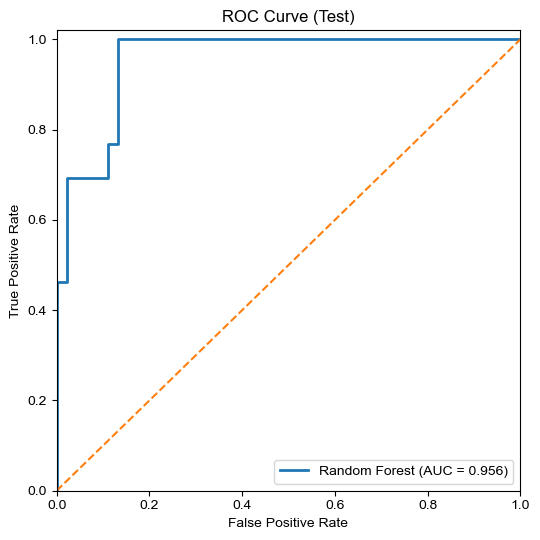

In [15]:
# ROC 曲线
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(5.5, 5.5))
plt.plot(fpr_rf, tpr_rf, lw=2, label='Random Forest (AUC = %0.3f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
#plt.savefig("RF_ROC_test.pdf", format='pdf', bbox_inches='tight')
#print("已保存：RF_ROC_test.pdf")

In [16]:
# =========================
# 保存模型
# =========================
import joblib
joblib.dump(best_model, 'RandomForest.pkl')
print("模型已保存为：RandomForest.pkl")

模型已保存为：RandomForest.pkl


In [17]:
# =========================
# Streamlit Frontend (Online Calculator)
# Run from terminal:  streamlit run <this_file>.py
# =========================
import streamlit as st
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

# Load model
@st.cache_resource
def load_model(path='RandomForest.pkl'):
    return joblib.load(path)

model = load_model('RandomForest.pkl')

# Feature names (must match the training data column names and order)
feature_names = [
    "Age",                  # continuous (years)
    "RBC",                  # continuous (10^12/L)
    "FIGO",                 # categorical (encoded as below)
    "Transverse_Diameter",  # continuous (mm)
    "Pelvic_Invasion",      # categorical (Negative/Positive)
    "Radiotherapy",         # categorical (4 levels)
    "LNM"                   # categorical (Negative/Positive)
]

st.title("Cervical Adenocarcinoma — Survival Risk Calculator (Random Forest)")
st.markdown("""
*Enter seven variables (Age, RBC, FIGO stage, tumor transverse diameter, pelvic wall invasion, radiotherapy type, and lymph node metastasis) to obtain the model prediction and a SHAP-based single-case interpretation.  
For research use only; not for clinical decision-making.*
""")

# ---------- Categorical mappings (MUST match the encodings used during training) ----------
FIGO_map = {
    "Carcinoma in situ": 0,
    "Stage I": 1,
    "Stage II": 2,
    "Stage III": 3,
    "Stage IV": 4
}
Pelvic_map = {"Negative": 0, "Positive": 1}
RT_map = {
    "No radiotherapy": 0,
    "Definitive radiotherapy": 1,
    "Postoperative radiotherapy": 2,
    "Preoperative brachytherapy": 3
}
LNM_map = {"Negative": 0, "Positive": 1}

# ---------- Continuous inputs ----------
Age = st.number_input("Age (years):", min_value=20, max_value=80, value=49, step=1)
RBC = st.number_input("RBC (10^12/L):", min_value=2.0, max_value=7.0, value=4.25, step=0.1, format="%.1f")
Transverse_Diameter = st.number_input("Tumor transverse diameter (mm):", min_value=0.0, max_value=200.0, value=50.0, step=1.0, format="%.1f")

# ---------- Categorical inputs ----------
FIGO_label = st.selectbox("FIGO stage:", options=list(FIGO_map.keys()), index=1)
Pelvic_label = st.selectbox("Pelvic wall invasion:", options=list(Pelvic_map.keys()), index=0)
RT_label = st.selectbox("Radiotherapy (RT):", options=list(RT_map.keys()), index=0)
LNM_label = st.selectbox("Lymph node metastasis (LNM):", options=list(LNM_map.keys()), index=0)

# ---------- Encode categoricals ----------
FIGO = FIGO_map[FIGO_label]
Pelvic_Invasion = Pelvic_map[Pelvic_label]
Radiotherapy = RT_map[RT_label]
LNM = LNM_map[LNM_label]

# ---------- Assemble single-sample DataFrame ----------
feature_values = [Age, RBC, FIGO, Transverse_Diameter, Pelvic_Invasion, Radiotherapy, LNM]
X_user = pd.DataFrame([feature_values], columns=feature_names)

# =========================
# Prediction + SHAP single-case force plot
# =========================
if st.button("Predict"):
    proba = model.predict_proba(X_user)[0]
    pred_class = int(np.argmax(proba))
    risk_prob = float(proba[1])  # assumes class "1" is the event/high-risk class

    st.subheader("Prediction")
    st.write(f"**Predicted Class (0 = Low risk, 1 = High risk):** {pred_class}")
    st.write(f"**Predicted Probability of Class 1:** {risk_prob:.3f}")

    if pred_class == 1:
        st.info(
            f"Model indicates higher risk (P(class=1) = {risk_prob*100:.1f}%). "
            "Consider integrating with clinical staging and treatment plans, and intensify follow-up when appropriate."
        )
    else:
        st.info(
            f"Model indicates relatively low risk (P(class=1) = {risk_prob*100:.1f}%). "
            "Routine follow-up is suggested while monitoring key risk factors (FIGO stage, pelvic invasion, LNM)."
        )

    # SHAP single-case explanation (RandomForest + TreeExplainer)
    try:
        explainer = shap.TreeExplainer(model, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_user)

        # Handle expected_value/shap_values as list or array
        if isinstance(explainer.expected_value, (list, np.ndarray)):
            base_value = explainer.expected_value[1] if len(np.atleast_1d(explainer.expected_value)) > 1 \
                         else np.atleast_1d(explainer.expected_value)[0]
        else:
            base_value = explainer.expected_value

        if isinstance(shap_values, list):
            shap_values_pos = shap_values[1]  # take SHAP for positive class (1)
        else:
            shap_values_pos = shap_values

        shap.force_plot(
            base_value,
            shap_values_pos[0],
            X_user.iloc[0],
            matplotlib=True, show=False
        )
        plt.tight_layout()
        plt.savefig("shap_force_rf_single.png", dpi=600, bbox_inches='tight')
        plt.close()

        st.subheader("SHAP Force Plot (single case)")
        st.image("shap_force_rf_single.png",
                 caption="Feature contributions toward the predicted probability (Class = 1)")

    except Exception as e:
        st.warning(f"SHAP plotting error: {e}")